In [ ]:
%pwd

'/content'

In [ ]:
import os
import pandas as pd
import numpy as np 
import pickle
from tqdm import tqdm

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

In [ ]:
data_path = '/content/drive/MyDrive/LPOINT'

In [ ]:
data = pd.read_csv(os.path.join(data_path, '제6회 L.POINT Big Data Competition-분석용데이터-01.온라인 행동 정보.csv'))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,7809,1,8,5,A03,20190913,01:16,2571103,NaN,NaN,34.0,2663.0,DIRECT,NaN
1,7809,1,4,2,A03,20190913,01:14,2485909,NaN,NaN,34.0,2663.0,DIRECT,NaN
2,7809,1,11,5,A03,20190913,01:17,2646597,NaN,NaN,34.0,2663.0,DIRECT,NaN
3,7809,1,1,2,A03,20190913,00:46,788304,NaN,NaN,34.0,2663.0,DIRECT,NaN
4,7809,1,9,5,A03,20190913,01:17,2617609,NaN,NaN,34.0,2663.0,DIRECT,NaN


In [ ]:
data.sech_kwd.unique()

array([nan, '버터', '카누', ..., '가이거세라믹시계', 'dlwkshrtm', '양가죽자켓 오야니'],
      dtype=object)

In [ ]:
clnt_sess_idx = []
for row_index, value in tqdm(data.drop_duplicates(['clnt_id','sess_id'])[['clnt_id','sess_id']].iterrows()):
#     print(value)
    clnt_id, sess_id = value[0], value[1]
    y = data[(data.clnt_id==clnt_id)&(data.sess_id==sess_id)]
    if y.shape[0] > 5:
      clnt_sess_idx.append((clnt_id,sess_id))

367149it [1:18:46, 77.68it/s]


In [ ]:
for row_index, value in tqdm(data.drop_duplicates(['clnt_id','sess_id'])[['clnt_id','sess_id']].iterrows()):
  print(value)
  break

0it [00:00, ?it/s]

clnt_id    7809
sess_id       1
Name: 0, dtype: int64


In [ ]:
clnt_sess_idx[0]

(7809, 1)

In [ ]:
len(clnt_sess_idx) # session 길이가 6 이상인 case 개수 

126934

In [ ]:
with open(os.path.join(data_path, "clnt_sess_idx.pickle"), "wb") as f:
  pickle.dump(clnt_sess_idx, f)

In [ ]:
with open(os.path.join(data_path, "clnt_sess_idx.pickle"), "rb") as f:
  clnt_sess_idx = pickle.load(f)

In [ ]:
new_clnt_id = list(map(lambda x: x[0], clnt_sess_idx))
new_sess_id = list(map(lambda x: x[1], clnt_sess_idx))


In [ ]:
new_data

In [ ]:
new_data = pd.DataFrame()

for clnt_id, sess_id in tqdm(zip(new_clnt_id, new_sess_id)):
  y = data[(data.clnt_id==clnt_id)&(data.sess_id==sess_id)]
  new_data = new_data.append(y)

126934it [4:14:48,  8.30it/s]


In [ ]:
# with open(os.path.join(data_path, "new_data.pickle"), "wb") as f:
#   pickle.dump(new_data, f)

In [ ]:
with open(os.path.join(data_path, "new_data.pickle"), "rb") as f:
  new_data = pickle.load(f)

In [ ]:
new_data.shape

(2706978, 14)

In [ ]:
new_data.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,7809,1,8,5,A03,20190913,01:16,2571103,NaN,NaN,34.0,2663.0,DIRECT,NaN
1,7809,1,4,2,A03,20190913,01:14,2485909,NaN,NaN,34.0,2663.0,DIRECT,NaN
2,7809,1,11,5,A03,20190913,01:17,2646597,NaN,NaN,34.0,2663.0,DIRECT,NaN
3,7809,1,1,2,A03,20190913,00:46,788304,NaN,NaN,34.0,2663.0,DIRECT,NaN
4,7809,1,9,5,A03,20190913,01:17,2617609,NaN,NaN,34.0,2663.0,DIRECT,NaN


In [ ]:
new_data = new_data.sort_values(by=['clnt_id','sess_id','hit_seq'])

In [ ]:
seq_df = new_data.groupby(['clnt_id','sess_id'])['action_type'].apply(lambda x:x.tolist()).reset_index()

In [ ]:
seq_df = seq_df[seq_df['action_type'].apply(lambda x : len(x)) > 6] # seq가 7 이상인 것들만

In [ ]:
seq_df.head()

,clnt_id,sess_id,action_type
0,1,2,"[0, 0, 0, 0, 0, 0, 0]"
1,2,1,"[0, 1, 2, 0, 0, 3, 5, 5, 0, 1, 2, 0, 0, 0, 5, ..."
3,2,7,"[0, 1, 2, 3, 5, 5, 2]"
4,2,8,"[5, 0, 1, 2, 1, 2, 1, 2, 3, 0, 5, 2, 0, 2, 2, ..."
6,2,10,"[0, 1, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."


In [ ]:
train_users = []
train_seqs = []
train_targets = []

test_users = []
test_seqs = []
test_targets = []

items_usr_clicked = {}

In [ ]:
len_Seq = 5
len_Pred = 1
len_Tag = 1

In [ ]:
for index, row in seq_df.iterrows():
  user = (row['clnt_id'], row['sess_id'])
  items = row['action_type']
  # import pdb;pdb.set_trace(tes)
  test_item = items[-1*len_Pred :]
  test_seq = items[-1* (len_Pred + len_Seq) :-1*len_Pred]
  test_users.append(user)
  test_seqs.append(test_seq)
  test_targets.append(test_item[0])

  train_build_items = items[:-1*len_Pred]

  items_usr_clicked[user] = train_build_items

  for i in range(len_Seq, len(train_build_items) - len_Tag + 1):
      item = train_build_items[i:i+ len_Tag]
      seq = train_build_items[max(0,i - len_Seq):i]

      train_users.append(user)
      train_seqs.append(seq)
      train_targets.append(item[0])

In [ ]:
d_train = pd.DataFrame({'user':train_users,'seq':train_seqs,'target':train_targets})
d_test = pd.DataFrame({'user': test_users, 'seq': test_seqs, 'target': test_targets})

In [ ]:
d_train

,user,seq,target
0,"(1, 2)","[0, 0, 0, 0, 0]",0
1,"(2, 1)","[0, 1, 2, 0, 0]",3
2,"(2, 1)","[1, 2, 0, 0, 3]",5
3,"(2, 1)","[2, 0, 0, 3, 5]",5
4,"(2, 1)","[0, 0, 3, 5, 5]",0
...,...,...,...
1945369,"(72427, 3)","[2, 1, 2, 1, 2]",1
1945370,"(72427, 3)","[1, 2, 1, 2, 1]",2
1945371,"(72427, 3)","[2, 1, 2, 1, 2]",5
1945372,"(72427, 3)","[1, 2, 1, 2, 5]",5


In [ ]:
d_test.head()

,user,seq,target
0,"(1, 2)","[0, 0, 0, 0, 0]",0
1,"(2, 1)","[3, 5, 5, 5, 5]",5
2,"(2, 7)","[1, 2, 3, 5, 5]",2
3,"(2, 8)","[5, 5, 5, 5, 5]",6
4,"(2, 10)","[5, 6, 1, 2, 1]",2


In [ ]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len


# LSTM modeling

## seq= 5

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = 5
input_size = 8
hidden_size = 128
num_layers = 2
num_classes = 8
batch_size = 512
num_epochs = 100
learning_rate = 0.01

In [ ]:
train_dataset = timeseries(d_train['seq'], (d_train['target']))
train_loader = DataLoader(train_dataset,shuffle=False,batch_size=batch_size)

In [ ]:
test_dataset = timeseries(d_test['seq'], (d_test['target']))
test_loader = DataLoader(test_dataset,shuffle=False, batch_size=batch_size)

In [ ]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (data, labels) in enumerate(train_loader):
        data = F.one_hot(data.to(torch.int64), num_classes = 8).to(device)
        labels = labels.to(device)

        
        # Forward pass
        outputs = model(data.to(torch.float))
        loss = criterion(outputs, labels.to(torch.int64))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1000 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        train_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(train_loader.sampler)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

Epoch [1/100], Step [1000/3800], Loss: 1.0069
Epoch [1/100], Step [2000/3800], Loss: 1.0862
Epoch [1/100], Step [3000/3800], Loss: 1.1508
Epoch [1/100], Loss: 1.0768
Epoch [2/100], Step [1000/3800], Loss: 1.0017
Epoch [2/100], Step [2000/3800], Loss: 1.0810
Epoch [2/100], Step [3000/3800], Loss: 1.1554
Epoch [2/100], Loss: 1.0535
Epoch [3/100], Step [1000/3800], Loss: 0.9955
Epoch [3/100], Step [2000/3800], Loss: 1.0768
Epoch [3/100], Step [3000/3800], Loss: 1.1552
Epoch [3/100], Loss: 1.0506
Epoch [4/100], Step [1000/3800], Loss: 0.9970
Epoch [4/100], Step [2000/3800], Loss: 1.0785
Epoch [4/100], Step [3000/3800], Loss: 1.1562
Epoch [4/100], Loss: 1.0491
Epoch [5/100], Step [1000/3800], Loss: 0.9932
Epoch [5/100], Step [2000/3800], Loss: 1.0763
Epoch [5/100], Step [3000/3800], Loss: 1.1539
Epoch [5/100], Loss: 1.0483
Epoch [6/100], Step [1000/3800], Loss: 0.9936
Epoch [6/100], Step [2000/3800], Loss: 1.0762
Epoch [6/100], Step [3000/3800], Loss: 1.1579
Epoch [6/100], Loss: 1.0475
Epoc

In [ ]:
torch.save(model, os.path.join(data_path, 'LSTM_seq_5.pt'))

In [ ]:
model = torch.load(os.path.join(data_path, 'LSTM_seq_5.pt'))

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test_loader:
        data = F.one_hot(data.to(torch.int64), num_classes = 8).to(device)
        labels = labels.to(device)
        outputs = model(data.to(torch.float))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the LSTM model: {} %'.format(100 * correct / total)) 

Test Accuracy of the LSTM model: 53.10126024499868 %


In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test_loader:
        data = F.one_hot(data.to(torch.int64), num_classes = 8).to(device)
        labels = labels.to(device)
        outputs = model(data.to(torch.float))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the LSTM model: {} %'.format(100 * correct / total)) 

Test Accuracy of the LSTM model: 53.10126024499868 %


In [ ]:
predicted

tensor([1, 0, 0, 0, 0, 3, 3, 5, 5, 5, 3, 5, 5, 4, 5, 5, 0, 4, 3, 5, 5, 5, 5, 5,
        0, 5, 5, 3, 0, 5, 0, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 2, 5, 5, 5,
        5, 2, 0, 5, 5, 5, 1, 3, 5, 3, 3, 5, 4, 3, 5, 2, 5, 5, 0, 0, 0, 0, 3, 0,
        2, 2, 3, 5, 5, 5, 5, 3, 5, 2, 2, 0, 5, 5, 2, 5, 2, 5, 5, 5, 0, 1, 5, 0,
        5, 0, 5, 5, 2, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 0, 5, 0, 0, 3, 1, 5, 5, 5,
        5, 5, 0, 5, 5, 2, 5, 5, 5, 5, 1, 3, 5, 5, 5, 5, 5, 2, 2, 5, 0, 0, 0, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 3, 5, 5, 0, 5, 5, 5, 4, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 5, 3, 1, 2, 0, 0, 0, 0, 1, 5, 2, 5, 5,
        5, 5, 5, 5, 2, 2, 0, 5, 5, 5, 2, 5, 5, 5, 5, 5, 0, 2, 0, 2, 5, 5, 2, 1,
        5, 2, 2, 3, 3, 2, 2, 2, 3, 5, 5, 2, 2, 2, 1, 3, 2, 3, 4, 3, 5, 2, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 2, 2, 5, 0, 0, 2,
        0, 1, 3, 1, 1, 0, 2, 1, 3, 2, 2, 2, 1, 2, 2, 1, 5, 1, 2, 5, 5, 2, 2, 1,
        5, 5, 2, 5, 2, 0, 0, 1, 0, 5, 5,

In [ ]:
labels

tensor([2., 0., 6., 0., 6., 0., 0., 5., 5., 5., 3., 5., 5., 5., 5., 6., 0., 0.,
        3., 6., 0., 6., 5., 6., 0., 0., 6., 0., 0., 6., 0., 2., 2., 0., 0., 0.,
        0., 6., 0., 0., 0., 0., 0., 6., 2., 2., 5., 5., 6., 2., 0., 3., 6., 0.,
        2., 3., 6., 0., 5., 6., 5., 2., 5., 2., 6., 6., 0., 0., 0., 6., 3., 0.,
        5., 2., 3., 6., 6., 6., 5., 3., 6., 1., 2., 0., 5., 5., 2., 6., 6., 2.,
        3., 6., 0., 0., 0., 0., 2., 3., 5., 6., 2., 5., 6., 5., 5., 6., 5., 6.,
        6., 5., 6., 0., 6., 3., 0., 5., 0., 5., 0., 6., 0., 6., 0., 6., 2., 7.,
        5., 5., 5., 3., 0., 5., 6., 5., 6., 6., 6., 2., 2., 5., 0., 0., 0., 5.,
        6., 6., 6., 6., 6., 5., 6., 5., 2., 6., 6., 0., 4., 6., 0., 5., 5., 5.,
        5., 5., 5., 0., 0., 6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 5.,
        5., 2., 2., 0., 0., 0., 0., 5., 6., 2., 5., 5., 5., 5., 5., 6., 2., 2.,
        3., 5., 5., 5., 2., 6., 0., 5., 6., 5., 0., 2., 0., 5., 6., 5., 2., 2.,
        0., 2., 2., 2., 3., 2., 2., 2., 

In [ ]:
df = pd.DataFrame({"Actual":labels.cpu(), "Predict":predicted.cpu()})

In [ ]:
import matplotlib.pyplot as plt

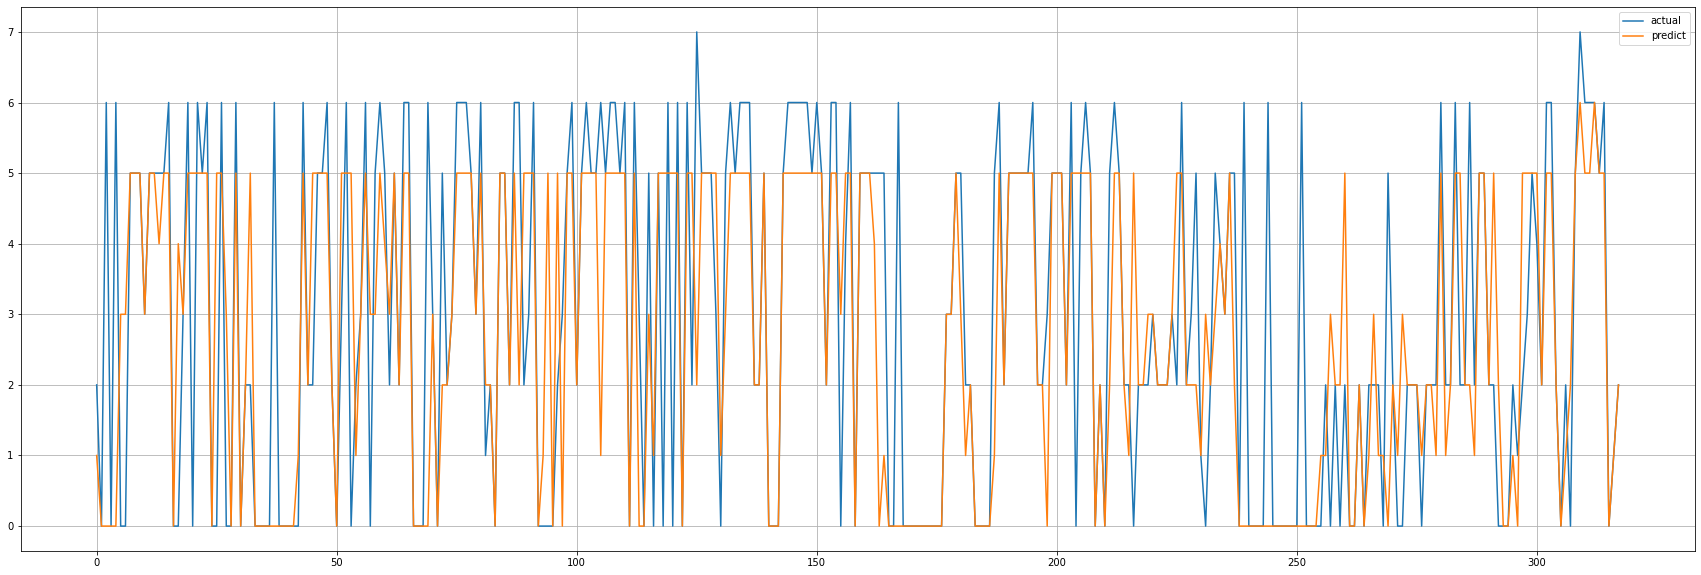

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(df['Actual'][:], label='actual')
plt.plot(df['Predict'][:], label='predict')
plt.legend()
plt.grid()
plt.show()

## seq=10 

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = 10
input_size = 8
hidden_size = 128
num_layers = 2
num_classes = 8
batch_size = 512
num_epochs = 100
learning_rate = 0.01

In [ ]:
seq_df = new_data.groupby(['clnt_id','sess_id'])['action_type'].apply(lambda x:x.tolist()).reset_index()

In [ ]:
seq_df = seq_df[seq_df['action_type'].apply(lambda x : len(x)) > 11] # seq가 12 이상인 것들만

In [ ]:
seq_df.head()

,clnt_id,sess_id,action_type
1,2,1,"[0, 1, 2, 0, 0, 3, 5, 5, 0, 1, 2, 0, 0, 0, 5, ..."
4,2,8,"[5, 0, 1, 2, 1, 2, 1, 2, 3, 0, 5, 2, 0, 2, 2, ..."
6,2,10,"[0, 1, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
9,2,15,"[2, 2, 1, 2, 0, 3, 5, 1, 2, 0, 3, 1, 2, 5, 5, ..."
10,2,16,"[1, 2, 0, 0, 0, 1, 2, 0, 0, 5, 2, 5]"


In [ ]:
train_users = []
train_seqs = []
train_targets = []

test_users = []
test_seqs = []
test_targets = []

items_usr_clicked = {}

In [ ]:
len_Seq = 10
len_Pred = 1
len_Tag = 1

In [ ]:
for index, row in seq_df.iterrows():
  user = (row['clnt_id'], row['sess_id'])
  items = row['action_type']
  # import pdb;pdb.set_trace(tes)
  test_item = items[-1*len_Pred :]
  test_seq = items[-1* (len_Pred + len_Seq) :-1*len_Pred]
  test_users.append(user)
  test_seqs.append(test_seq)
  test_targets.append(test_item[0])

  train_build_items = items[:-1*len_Pred]

  items_usr_clicked[user] = train_build_items

  for i in range(len_Seq, len(train_build_items) - len_Tag + 1):
      item = train_build_items[i:i+ len_Tag]
      seq = train_build_items[max(0,i - len_Seq):i]

      train_users.append(user)
      train_seqs.append(seq)
      train_targets.append(item[0])

In [ ]:
d_train = pd.DataFrame({'user':train_users,'seq':train_seqs,'target':train_targets})
d_test = pd.DataFrame({'user': test_users, 'seq': test_seqs, 'target': test_targets})

In [ ]:
seq_df.head()

,clnt_id,sess_id,action_type
1,2,1,"[0, 1, 2, 0, 0, 3, 5, 5, 0, 1, 2, 0, 0, 0, 5, ..."
4,2,8,"[5, 0, 1, 2, 1, 2, 1, 2, 3, 0, 5, 2, 0, 2, 2, ..."
6,2,10,"[0, 1, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
9,2,15,"[2, 2, 1, 2, 0, 3, 5, 1, 2, 0, 3, 1, 2, 5, 5, ..."
10,2,16,"[1, 2, 0, 0, 0, 1, 2, 0, 0, 5, 2, 5]"


In [ ]:
d_train

,user,seq,target
0,"(2, 1)","[0, 1, 2, 0, 0, 3, 5, 5, 0, 1]",2
1,"(2, 1)","[1, 2, 0, 0, 3, 5, 5, 0, 1, 2]",0
2,"(2, 1)","[2, 0, 0, 3, 5, 5, 0, 1, 2, 0]",0
3,"(2, 1)","[0, 0, 3, 5, 5, 0, 1, 2, 0, 0]",0
4,"(2, 1)","[0, 3, 5, 5, 0, 1, 2, 0, 0, 0]",5
...,...,...,...
1469980,"(72427, 3)","[1, 2, 1, 2, 1, 2, 1, 2, 1, 2]",1
1469981,"(72427, 3)","[2, 1, 2, 1, 2, 1, 2, 1, 2, 1]",2
1469982,"(72427, 3)","[1, 2, 1, 2, 1, 2, 1, 2, 1, 2]",5
1469983,"(72427, 3)","[2, 1, 2, 1, 2, 1, 2, 1, 2, 5]",5


In [ ]:
d_test.head()

,user,seq,target
0,"(2, 1)","[5, 5, 5, 5, 6, 3, 5, 5, 5, 5]",5
1,"(2, 8)","[5, 2, 2, 5, 5, 5, 5, 5, 5, 5]",6
2,"(2, 10)","[5, 5, 5, 5, 5, 5, 6, 1, 2, 1]",2
3,"(2, 15)","[0, 1, 2, 5, 5, 5, 1, 2, 5, 0]",0
4,"(2, 16)","[2, 0, 0, 0, 1, 2, 0, 0, 5, 2]",5


In [ ]:
train_dataset = timeseries(d_train['seq'], (d_train['target']))
train_loader = DataLoader(train_dataset,shuffle=False,batch_size=batch_size)

In [ ]:
test_dataset = timeseries(d_test['seq'], (d_test['target']))
test_loader = DataLoader(test_dataset,shuffle=False, batch_size=batch_size)

In [ ]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (data, labels) in enumerate(train_loader):
        data = F.one_hot(data.to(torch.int64), num_classes = 8).to(device)
        labels = labels.to(device)

        
        # Forward pass
        outputs = model(data.to(torch.float))
        loss = criterion(outputs, labels.to(torch.int64))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1000 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        train_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(train_loader.sampler)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

Epoch [1/100], Step [1000/2872], Loss: 1.0113
Epoch [1/100], Step [2000/2872], Loss: 0.9273
Epoch [1/100], Loss: 1.0646
Epoch [2/100], Step [1000/2872], Loss: 0.9943
Epoch [2/100], Step [2000/2872], Loss: 0.9180
Epoch [2/100], Loss: 1.0314
Epoch [3/100], Step [1000/2872], Loss: 0.9906
Epoch [3/100], Step [2000/2872], Loss: 0.9142
Epoch [3/100], Loss: 1.0270
Epoch [4/100], Step [1000/2872], Loss: 0.9891
Epoch [4/100], Step [2000/2872], Loss: 0.9137
Epoch [4/100], Loss: 1.0242
Epoch [5/100], Step [1000/2872], Loss: 0.9859
Epoch [5/100], Step [2000/2872], Loss: 0.9128
Epoch [5/100], Loss: 1.0223
Epoch [6/100], Step [1000/2872], Loss: 0.9852
Epoch [6/100], Step [2000/2872], Loss: 0.9089
Epoch [6/100], Loss: 1.0208
Epoch [7/100], Step [1000/2872], Loss: 0.9852
Epoch [7/100], Step [2000/2872], Loss: 0.9082
Epoch [7/100], Loss: 1.0191
Epoch [8/100], Step [1000/2872], Loss: 0.9851
Epoch [8/100], Step [2000/2872], Loss: 0.9085
Epoch [8/100], Loss: 1.0179
Epoch [9/100], Step [1000/2872], Loss: 0

In [ ]:
torch.save(model, os.path.join(data_path, 'LSTM_seq_10.pt'))

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test_loader:
        data = F.one_hot(data.to(torch.int64), num_classes = 8).to(device)
        labels = labels.to(device)
        outputs = model(data.to(torch.float))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the LSTM model: {} %'.format(100 * correct / total)) 

Test Accuracy of the LSTM model: 49.68414787560702 %


## new information 추가

In [ ]:
new_data.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
3091872,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app
3142610,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app
3084082,1,2,3,0,A01,20190922,14:10,70025,NaN,초등남아옷,45.0,424.0,unknown,mobile_app
3136926,1,2,4,0,A01,20190922,14:11,119527,NaN,초등남아점퍼,45.0,424.0,unknown,mobile_app
3123796,1,2,5,0,A01,20190922,14:11,162327,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app


biz_unit: ['A01', 'A02', 'A03']

In [ ]:
np.unique(new_data.biz_unit, return_counts=True)

(array(['A01', 'A02', 'A03'], dtype=object),
 array([  97928,  463008, 2146042]))

In [ ]:
type(new_data.sess_dt[0])

numpy.int64

요일 (weekday)

In [ ]:
sess_date = pd.to_datetime(new_data.sess_dt.astype(str), format='%Y%m%d')

In [ ]:
weekday = sess_date.apply(lambda x: x.weekday())

In [ ]:
weekday.head()

3091872    6
3142610    6
3084082    6
3136926    6
3123796    6
Name: sess_dt, dtype: int64

In [ ]:
len(weekday)

2706978

{0: '월요일', 1:'화요일', 2:'수요일', 3:'목요일', 4:'금요일', 5:'토요일',6:'일요일'}

접속한 시간 (hour) 

In [ ]:
type(new_data.hit_tm[0])

str

In [ ]:
from datetime import datetime
datetime.strptime(new_data.hit_tm[0], '%H:%M')

datetime.datetime(1900, 1, 1, 1, 16)

In [ ]:
np.sort(new_data.hit_tm.apply(lambda x: x[:2]).unique())

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23'], dtype=object)

In [ ]:
hour = new_data.hit_tm.apply(lambda x: int(x[:2]))

In [ ]:
hour

3091872    14
3142610    14
3084082    14
3136926    14
3123796    14
           ..
2080969    11
2080960    11
2080964    11
2080959    11
2080958    11
Name: hit_tm, Length: 2706978, dtype: int64

각 action 별 머문 시간 (hit_pss_tm의 차분 계산)

In [ ]:
action_tm = new_data.hit_pss_tm.diff()[1:]
action_tm

3142610     14529.0
3084082     13912.0
3136926     49502.0
3123796     42800.0
3001880     16505.0
             ...   
2080969      1932.0
2080960    337103.0
2080964     27885.0
2080959    417673.0
2080958     11684.0
Name: hit_pss_tm, Length: 2706977, dtype: float64

In [ ]:
action_tm = new_data.groupby(['clnt_id','sess_id'])['hit_pss_tm'].apply(lambda x: x.diff().fillna(new_data['hit_pss_tm']))

In [ ]:
new_data[new_data.clnt_id==1]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
3091872,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app
3142610,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app
3084082,1,2,3,0,A01,20190922,14:10,70025,NaN,초등남아옷,45.0,424.0,unknown,mobile_app
3136926,1,2,4,0,A01,20190922,14:11,119527,NaN,초등남아점퍼,45.0,424.0,unknown,mobile_app
3123796,1,2,5,0,A01,20190922,14:11,162327,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app
3001880,1,2,6,0,A01,20190922,14:12,178832,NaN,노스페이스초등,45.0,424.0,unknown,mobile_app
3142609,1,2,7,0,A01,20190922,14:12,192367,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app


In [ ]:
action_tm[:20]

3091872    41584.0
3142610    14529.0
3084082    13912.0
3136926    49502.0
3123796    42800.0
3001880    16505.0
3142609    13535.0
2838680    39532.0
1427751     7700.0
1427590      855.0
2838670    14707.0
2838699    41280.0
1427709    23733.0
1427712     8518.0
1427761    14009.0
2838693    13089.0
1427623    11077.0
1427631     1359.0
2838704    12277.0
2838707    11379.0
Name: hit_pss_tm, dtype: float64

In [ ]:
# normalize
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
scale_action_tm = min_max_scaler.fit_transform(action_tm.values.reshape(-1,1))


In [ ]:
scale_action_tm = scale_action_tm.squeeze()
scale_action_tm

array([0.57188046, 0.57071134, 0.57068468, ..., 0.57128849, 0.58813229,
       0.5705884 ])

## action type + new information 

In [ ]:
def one_hot_encoding(value, length):
  one_hot_vector = [0] * length
  one_hot_vector[value] = 1
  return one_hot_vector

In [ ]:
def series_to_seq(df, column):
  new_df = df.groupby(['clnt_id', 'sess_id'])[f'{column}'].apply(lambda x: x.tolist()).reset_index()
  return new_df

In [ ]:
def cut_sequence(df, column, seq):
  new_df = df[df[f'{column}'].apply(lambda x : len(x)) >= seq]
  return new_df

In [ ]:
seq_df  # seq 7 이상

,clnt_id,sess_id,action_type
0,1,2,"[0, 0, 0, 0, 0, 0, 0]"
1,2,1,"[0, 1, 2, 0, 0, 3, 5, 5, 0, 1, 2, 0, 0, 0, 5, ..."
3,2,7,"[0, 1, 2, 3, 5, 5, 2]"
4,2,8,"[5, 0, 1, 2, 1, 2, 1, 2, 3, 0, 5, 2, 0, 2, 2, ..."
6,2,10,"[0, 1, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
...,...,...,...
126929,72424,1,"[2, 3, 3, 3, 3, 3, 3, 0, 1, 2, 0, 1, 2, 0, 1, ..."
126930,72424,2,"[2, 1, 2, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 3, 1, ..."
126931,72425,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
126932,72426,1,"[2, 0, 1, 2, 0, 2, 0, 1]"


In [ ]:
len(new_data)

In [ ]:
biz_unit = series_to_seq(new_data, 'biz_unit')
biz_unit

,clnt_id,sess_id,biz_unit
0,1,2,"[A01, A01, A01, A01, A01, A01, A01]"
1,2,1,"[A03, A03, A03, A03, A03, A03, A03, A03, A03, ..."
2,2,2,"[A03, A03, A03, A03, A03, A03]"
3,2,7,"[A03, A03, A03, A03, A03, A03, A03]"
4,2,8,"[A03, A03, A03, A03, A03, A03, A03, A03, A03, ..."
...,...,...,...
126929,72424,1,"[A03, A03, A03, A03, A03, A03, A03, A03, A03, ..."
126930,72424,2,"[A03, A03, A03, A03, A03, A03, A03, A03, A03, ..."
126931,72425,3,"[A01, A01, A01, A01, A01, A01, A01, A01, A01, ..."
126932,72426,1,"[A03, A03, A03, A03, A03, A03, A03, A03]"


In [ ]:
biz_unit = cut_sequence(biz_unit, 'biz_unit', 7)
biz_unit

,clnt_id,sess_id,biz_unit
0,1,2,"[A01, A01, A01, A01, A01, A01, A01]"
1,2,1,"[A03, A03, A03, A03, A03, A03, A03, A03, A03, ..."
3,2,7,"[A03, A03, A03, A03, A03, A03, A03]"
4,2,8,"[A03, A03, A03, A03, A03, A03, A03, A03, A03, ..."
6,2,10,"[A03, A03, A03, A03, A03, A03, A03, A03, A03, ..."
...,...,...,...
126929,72424,1,"[A03, A03, A03, A03, A03, A03, A03, A03, A03, ..."
126930,72424,2,"[A03, A03, A03, A03, A03, A03, A03, A03, A03, ..."
126931,72425,3,"[A01, A01, A01, A01, A01, A01, A01, A01, A01, ..."
126932,72426,1,"[A03, A03, A03, A03, A03, A03, A03, A03]"


In [ ]:
new_info = pd.DataFrame({"clnt_id":new_data.clnt_id, "sess_id":new_data.sess_id, "weekday":weekday, "hour":hour, "action_tm":scale_action_tm})
new_info

,clnt_id,sess_id,weekday,hour,action_tm
3091872,1,2,6,14,0.571880
3142610,1,2,6,14,0.570711
3084082,1,2,6,14,0.570685
3136926,1,2,6,14,0.572223
3123796,1,2,6,14,0.571933
...,...,...,...,...,...
2080969,72427,3,0,11,0.570167
2080960,72427,3,0,11,0.584651
2080964,72427,3,0,11,0.571288
2080959,72427,3,0,11,0.588132


In [ ]:
weekday_df = series_to_seq(new_info, "weekday")
hour_df = series_to_seq(new_info, "hour")
action_tm_df = series_to_seq(new_info, "action_tm")

In [ ]:
weekday_df[['weekday']]

,weekday
0,"[6, 6, 6, 6, 6, 6, 6]"
1,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
2,"[0, 0, 0, 0, 0, 0]"
3,"[2, 2, 2, 2, 2, 2, 2]"
4,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
...,...
126929,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
126930,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
126931,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
126932,"[0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
pdList = [biz_unit, weekday_df[['weekday']], hour_df[['hour']], action_tm_df[['action_tm']]]
new_info_df = pd.concat(pdList, axis=1)

In [ ]:
pd.isnull(new_info_df).sum(axis=0)

clnt_id      0
sess_id      0
biz_unit     0
weekday      0
hour         0
action_tm    0
dtype: int64

In [ ]:
new_info_df

,clnt_id,sess_id,biz_unit,weekday,hour,action_tm
0,1,2,"[A01, A01, A01, A01, A01, A01, A01]","[6, 6, 6, 6, 6, 6, 6]","[14, 14, 14, 14, 14, 14, 14]","[0.5718804591160632, 0.5707113391628437, 0.570..."
1,2,1,"[A03, A03, A03, A03, A03, A03, A03, A03, A03, ...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 2...","[0.5717917866287594, 0.5704162395450082, 0.570..."
2,2,2,"[A03, A03, A03, A03, A03, A03]","[0, 0, 0, 0, 0, 0]","[7, 7, 7, 7, 7, 7]","[0.5706876153833457, 0.5704927260472148, 0.573..."
3,2,7,"[A03, A03, A03, A03, A03, A03, A03]","[2, 2, 2, 2, 2, 2, 2]","[18, 18, 18, 18, 18, 18, 18]","[0.5740146485911921, 0.5701352704843601, 0.570..."
4,2,8,"[A03, A03, A03, A03, A03, A03, A03, A03, A03, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[0.5701778782194876, 0.5703232025736801, 0.571..."
...,...,...,...,...,...,...
126929,72424,1,"[A03, A03, A03, A03, A03, A03, A03, A03, A03, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, ...","[0.5802019312798595, 0.5715584379779597, 0.582..."
126930,72424,2,"[A03, A03, A03, A03, A03, A03, A03, A03, A03, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1...","[0.5737508781903623, 0.5729499305528488, 0.570..."
126931,72425,3,"[A01, A01, A01, A01, A01, A01, A01, A01, A01, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 2...","[0.5710508614497573, 0.5734478706460275, 0.573..."
126932,72426,1,"[A03, A03, A03, A03, A03, A03, A03, A03]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.5700934837907817, 0.5724516015452521, 0.572..."


In [ ]:
biz_integer = {'A01':0, 'A02':1, 'A03':2}

In [ ]:
new_info_df.biz_unit = new_info_df.biz_unit.apply(lambda x: [biz_integer[val] for val in x])

In [ ]:
new_info_df.head()

,clnt_id,sess_id,biz_unit,weekday,hour,action_tm
0,1,2,"[0, 0, 0, 0, 0, 0, 0]","[6, 6, 6, 6, 6, 6, 6]","[14, 14, 14, 14, 14, 14, 14]","[0.5718804591160632, 0.5707113391628437, 0.570..."
1,2,1,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 2...","[0.5717917866287594, 0.5704162395450082, 0.570..."
2,2,2,"[2, 2, 2, 2, 2, 2]","[0, 0, 0, 0, 0, 0]","[7, 7, 7, 7, 7, 7]","[0.5706876153833457, 0.5704927260472148, 0.573..."
3,2,7,"[2, 2, 2, 2, 2, 2, 2]","[2, 2, 2, 2, 2, 2, 2]","[18, 18, 18, 18, 18, 18, 18]","[0.5740146485911921, 0.5701352704843601, 0.570..."
4,2,8,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[0.5701778782194876, 0.5703232025736801, 0.571..."


In [ ]:
new_info_df.biz_unit = new_info_df.biz_unit.apply(lambda x: [one_hot_encoding(val, 3) for val in x])
new_info_df.weekday = new_info_df.weekday.apply(lambda x: [one_hot_encoding(val, 7) for val in x])
new_info_df.hour = new_info_df.hour.apply(lambda x: [one_hot_encoding(val, 24) for val in x])

In [ ]:
new_info_df.head()

,clnt_id,sess_id,biz_unit,weekday,hour,action_tm
0,1,2,"[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [...","[[0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1],...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[0.5718804591160632, 0.5707113391628437, 0.570..."
1,2,1,"[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [...","[[0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1],...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.5717917866287594, 0.5704162395450082, 0.570..."
2,2,2,"[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [...","[[1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0],...","[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,...","[0.5706876153833457, 0.5704927260472148, 0.573..."
3,2,7,"[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [...","[[0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.5740146485911921, 0.5701352704843601, 0.570..."
4,2,8,"[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [...","[[0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.5701778782194876, 0.5703232025736801, 0.571..."


In [ ]:
new_info_df = cut_sequence(new_info_df, "action_tm", 7)

In [ ]:
seq_df

,clnt_id,sess_id,action_type
0,1,2,"[0, 0, 0, 0, 0, 0, 0]"
1,2,1,"[0, 1, 2, 0, 0, 3, 5, 5, 0, 1, 2, 0, 0, 0, 5, ..."
3,2,7,"[0, 1, 2, 3, 5, 5, 2]"
4,2,8,"[5, 0, 1, 2, 1, 2, 1, 2, 3, 0, 5, 2, 0, 2, 2, ..."
6,2,10,"[0, 1, 2, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
...,...,...,...
126929,72424,1,"[2, 3, 3, 3, 3, 3, 3, 0, 1, 2, 0, 1, 2, 0, 1, ..."
126930,72424,2,"[2, 1, 2, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 3, 1, ..."
126931,72425,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
126932,72426,1,"[2, 0, 1, 2, 0, 2, 0, 1]"


In [ ]:
seq_df.action_type = seq_df.action_type.apply(lambda x: [one_hot_encoding(val, 8) for val in x])

In [ ]:
final_df = pd.concat([seq_df, new_info_df.drop(columns=['clnt_id','sess_id'])], axis=1)
final_df.head()

,clnt_id,sess_id,action_type,biz_unit,weekday,hour,action_tm
0,1,2,"[[1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, ...","[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [...","[[0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1],...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[0.5718804591160632, 0.5707113391628437, 0.570..."
1,2,1,"[[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, ...","[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [...","[[0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1],...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.5717917866287594, 0.5704162395450082, 0.570..."
3,2,7,"[[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, ...","[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [...","[[0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.5740146485911921, 0.5701352704843601, 0.570..."
4,2,8,"[[0, 0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, ...","[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [...","[[0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.5701778782194876, 0.5703232025736801, 0.571..."
6,2,10,"[[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, ...","[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [...","[[0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0],...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.5707561939590529, 0.5701363508021879, 0.570..."


In [ ]:
with open(os.path.join(data_path, "final_df.pickle"), "wb") as f:
  pickle.dump(final_df, f)

In [ ]:
with open(os.path.join(data_path, "final_df.pickle"), "rb") as f:
  final_df = pickle.load(f)

In [ ]:
final_df.action_tm = final_df.action_tm.apply(lambda x: [[val] for val in x])

In [ ]:
a = np.array(final_df.action_type[0])

In [ ]:
b = np.array(final_df.biz_unit[0])

In [ ]:
np.concatenate((a,b), axis=1)

array([[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [ ]:
zip_feature = list(zip(final_df.action_type, final_df.biz_unit, final_df.weekday, final_df.hour, final_df.action_tm))

In [ ]:
len(zip_feature[0])

5

In [ ]:
def hello(x):
  a, b, c, d, e = np.array(x[0]), np.array(x[1]), np.array(x[2]), np.array(x[3]), np.array(x[4])
  return np.concatenate((a,b,c,d,e), axis=1)


In [ ]:
concat_feature = list(map(hello, zip_feature))

In [ ]:
len(concat_feature)

113470